
##### Data fields
- patientId - A patientId. Each patientId corresponds to a unique image.
- x - the upper-left x coordinate of the bounding box.
- y - the upper-left y coordinate of the bounding box.
- width - the width of the bounding box.
- height - the height of the bounding box.
- Target - the binary Target, indicating whether this sample has evidence of pneumonia.

#### Summary
The goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related. In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

**Dicom original images**: Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.


In [1]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings

warnings.filterwarnings('ignore')
import random
import zipfile
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=120)
import seaborn as sns
sns.set(style='whitegrid') #set seaborn plotting aesthetics
%matplotlib inline

import cv2
import os
import csv
from pathlib import Path
import pydicom
from glob import glob
from matplotlib.patches import Rectangle

from tqdm import tqdm_notebook

np.random.seed(2023)

<Figure size 1800x1440 with 0 Axes>

In [3]:
cwd = os.getcwd()

In [4]:
cwd

'/content'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [7]:
cwd = os.getcwd()
cwd

'/content/drive/MyDrive/Colab Notebooks'

In [ ]:
#!unzip "stage_2_train_images.zip" -d ""

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/f868de0f-be9e-4da2-aee7-b0bc5b66e086.dcm  
  inflating: __MACOSX/stage_2_train_images/._f868de0f-be9e-4da2-aee7-b0bc5b66e086.dcm  
  inflating: stage_2_train_images/bfdbe64f-1ab9-4b72-a4b5-3ef6a057add2.dcm  
  inflating: __MACOSX/stage_2_train_images/._bfdbe64f-1ab9-4b72-a4b5-3ef6a057add2.dcm  
  inflating: stage_2_train_images/4dbc44ca-694a-4814-9a24-bc60c8d8d611.dcm  
  inflating: __MACOSX/stage_2_train_images/._4dbc44ca-694a-4814-9a24-bc60c8d8d611.dcm  
  inflating: stage_2_train_images/eb056e61-98f0-418d-a5e9-b82bd8d2db93.dcm  
  inflating: __MACOSX/stage_2_train_images/._eb056e61-98f0-418d-a5e9-b82bd8d2db93.dcm  
  inflating: stage_2_train_images/379ee9d4-4c6f-41ca-a9ec-9c07bc721f7d.dcm  
  inflating: __MACOSX/stage_2_train_images/._379ee9d4-4c6f-41ca-a9ec-9c07bc721f7d.dcm  
  inflating: stage_2_train_images/eec65a2f-9b12-4884-b7b5-3707751332b9.dcm  
  inflating: __MACOSX/stage_2_train_images/._ee

In [ ]:
#!unzip "stage_2_test_images.zip" -d ""

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_test_images/2836c671-b555-4af7-b1c2-25d73cb113f1.dcm  
  inflating: __MACOSX/stage_2_test_images/._2836c671-b555-4af7-b1c2-25d73cb113f1.dcm  
  inflating: stage_2_test_images/1e2c8423-ba80-47dc-b590-841c472cbc27.dcm  
  inflating: __MACOSX/stage_2_test_images/._1e2c8423-ba80-47dc-b590-841c472cbc27.dcm  
  inflating: stage_2_test_images/1eda3687-bdf5-469f-8fba-5000c559f48b.dcm  
  inflating: __MACOSX/stage_2_test_images/._1eda3687-bdf5-469f-8fba-5000c559f48b.dcm  
  inflating: stage_2_test_images/243be28d-f021-457f-b86c-95394c9be74c.dcm  
  inflating: __MACOSX/stage_2_test_images/._243be28d-f021-457f-b86c-95394c9be74c.dcm  
  inflating: stage_2_test_images/2cdd3a1a-75d5-45bb-b8b4-0568cadd3f2b.dcm  
  inflating: __MACOSX/stage_2_test_images/._2cdd3a1a-75d5-45bb-b8b4-0568cadd3f2b.dcm  
  inflating: stage_2_test_images/00edcd2d-d727-486d-b15a-675855e4dca3.dcm  
  inflating: __MACOSX/stage_2_test_images/._00edcd2d-d727-

In [ ]:
# Reading the data

train_labels = pd.read_csv('stage_2_train_labels.csv')
train_class = pd.read_csv('stage_2_detailed_class_info.csv')

In [ ]:
train_path = os.listdir(Path('stage_2_train_images'))

In [ ]:
test_path = os.listdir(Path('stage_2_test_images'))

In [ ]:
print(f'Train Labels dataframe has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info dataframe has {train_class.shape[0]} rows and {train_class.shape[1]} columns')

Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns


In [ ]:
print('Duplicate records in train_labels:', train_labels.duplicated().sum())
print('Number of duplicates in patientID in train labels dataframe: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Number of duplicates in patientID in class info dataframe: {}'.format(len(train_class) - (train_class['patientId'].nunique())))

Duplicate records in train_labels: 0
Number of duplicates in patientID in train labels dataframe: 3543
Number of duplicates in patientID in class info dataframe: 3543


In [ ]:
print(train_labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None


In [ ]:
print(train_labels.head(15))

                               patientId      x      y  width  height  Target
0   0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1   00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2   00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3   003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6   00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7   006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
10  008c19e8-a820-403a-930a-bc74a4053664    NaN    NaN    NaN     NaN       0
11  009482dc-3db5-48d4-8580-5c89c4f01334    NaN    NaN    NaN   

#### Each record in the train_labels table contains:
- a patientId (one unique value per patient)
- corresponding abnormality bounding box defined by the upper-left hand corner (x, y) coordinate
- a target (either 0 or 1 for absence or presence of pneumonia, respectively)

#### There are many NaN values in four columns. But they seem to follow a trend.
- For each record in which we have any of value in the tuple (x,y,width,height) as NeN, the other 3 will also be NaN.
- This seems plausible. x and y are values of a tuple. Together they stand for a location, and width and height also form a pair. All four, together, define the bound of the abnormality in on the lung, called as opacity.
- All will be NaN together, or none will.
- If the values in the tuple (x,y,width,height) is NaN, then the value in the column 'Target' is definitely 0, that is, the patient is not pneumonic.
- Target, as per data dictionary, stands for whether the patient is pneuomonic or not. And in this study, we are looking for the same through an analysis of images.

In [ ]:
# confirming the connection between pnuemonia and presence of 'abrnomality' on the lung
print("The number of unique Target values when the feature has value NaN:", len(train_labels[train_labels.x.isna()]['Target'].unique()))
print('Number of Duplicated records in train_labels file:', train_class.duplicated().sum())

The number of unique Target values when the feature has value NaN: 1
Number of Duplicated records in train_labels file: 3543


- Number of unqiue values turn out to be 1, which imply all patients for whom the record shows absence of 'abnormality', will be non-pneumonic.
- Continuing, thus the missing values in the dataset have a reason. There are empty non-existent values conditioned on Target being 1 or zero. In other words, the Target column is dependent on the tuple of these four features. We don't need it. We won't remove it though. This is out prediction variable. Instead, we will match the values in this table withe images and perform out analysis.

In [ ]:
print(train_class.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB
None


In [ ]:
print(train_class.head(15))

                               patientId                         class
0   0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1   00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2   00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3   003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4   00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5   00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6   00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7   006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8   00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9   00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
10  008c19e8-a820-403a-930a-bc74a4053664  No Lung Opacity / Not Normal
11  009482dc-3db5-48d4-8580-5c89c4f01334                        Normal
12  009eb222-eabc-4150-8121-d5a6d06b8ebf                        Normal
13  00

In [ ]:
# Dropping duplicate records from train_class
train_class.drop_duplicates(inplace = True)
print('Number of Duplicated records in train_labels file:', train_class.duplicated().sum())

Number of Duplicated records in train_labels file: 0


##### Each record in the train_class table contains
- patientId
- class

##### There are no missing values, as is clear from the info() table.
##### From the same table, it's clear that the number of records in the two tables: train_class and train_labels is same: 30227

No. of unique patientId values in train_class:  26684
No. of unique patientId values in train_label:  26684
Distribution of the classes:


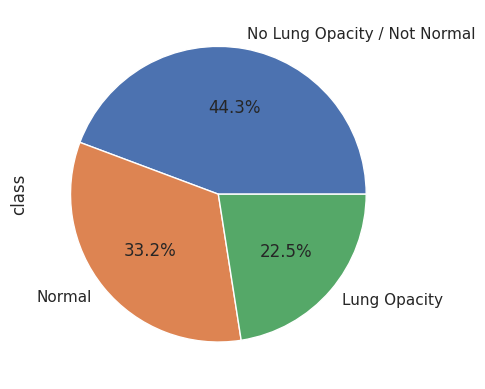

In [ ]:
# checking for unique patientId values. 
print('No. of unique patientId values in train_class: ', train_class['patientId'].nunique())
print('No. of unique patientId values in train_label: ', train_labels.patientId.nunique())
print('Distribution of the classes:')
train_class['class'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

##### Number of patientIds are same in both the train_labels dataset and train_class.

### Labels

- 'Normal' indicates that the lung x-ray is normal, and so is the lung.
- 'Lung Opacity' confirms that the the lung has opacity and is indicative of pneumonia.
- 'No Lung Opacity / Not Normal' indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

The third label is going to be challenging. These images have some abnormality, but they are not pneumomic. Our machine learning algorithm should be able to read this into the images, and not get fooled. In other words, it should be able to correctly classify the abnormal images into 'with pnuemonia' and 'without pneumonia'.


Also, there's a relatively uniform split between the three classes, with nearly 2/3rd of the data comprising of no pneumonia (either completely normal or no lung opacity / not normal). Compared to most medical imaging datasets, where the prevalence of disease is quite low, this dataset has been significantly enriched with pathology.

Let's analyze the distribution of the Target values in train_labels.

Distribution of Target values 
 0    20672
1     9555
Name: Target, dtype: int64


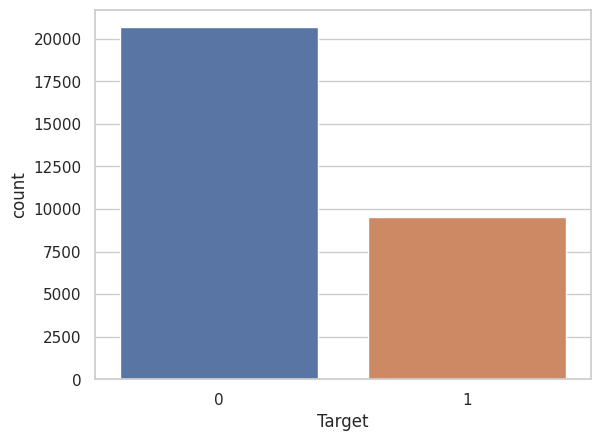

In [ ]:
print('Distribution of Target values','\n',train_labels['Target'].value_counts())
sns.countplot(x=train_labels['Target'])
plt.show()

There are 9555 records with Target = 1 and same number of records with class = Lung Opacity. We don't need to analyze the data with code to know that they corressspond to the same patientId. If the x-ray of a patient has region(s) of lung opacity, then they are pneumonic.

##### merging train_labels & train_class into train_meta

In [ ]:
train_meta = pd.merge(train_labels, train_class)

In [ ]:
# Checking info and a few random samples of newly created train_meta to verify
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
train_meta.sample(15)

patientId      x      y  width  height  \
27187  f1b5275a-4b98-4710-87c3-caf6ff7c3ab6    NaN    NaN    NaN     NaN   
7487   5776eae9-886b-4027-bcec-4ade9a431014  713.0  536.0  173.0   236.0   
2174   29e75170-ef12-4e4d-a0fc-4055fe7470c5    NaN    NaN    NaN     NaN   
15394  9680a3f0-01ca-4c8b-8d09-d209f72108ea    NaN    NaN    NaN     NaN   
17262  a5414ce7-41ac-4f20-8e35-1f8d79e5a911    NaN    NaN    NaN     NaN   
13176  850c772b-b01b-42e6-87f8-d097e92ae793    NaN    NaN    NaN     NaN   
28386  fb4d9f1d-83f9-42b6-9237-0b249b610206    NaN    NaN    NaN     NaN   
19941  b7f61871-5e78-4b27-bcc8-7c452c4c746a  177.0  537.0  227.0   317.0   
18460  ae1a7456-d4f8-4f0e-9764-ee93b0ec3245  322.0  456.0  177.0   193.0   
9943   6b56a3bd-389f-464c-a506-c20d2a2d5b0d  623.0  257.0  222.0   497.0   
1756   188218bc-84f2-4103-8e34-0dd6d3103b2f  533.0  378.0  272.0   279.0   
20459  bb4074e6-6327-44cd-b356-9ad42342e076  647.0  539.0  235.0   337.0   
26380  eb7aa38d-ba9a-4e37-a689-27af5e82c052    NaN    NaN    NaN     NaN   
15310  95c66d37-862d-491f-b82f-cfc8f18e3e48    NaN    NaN    NaN     NaN   
5481   471ea4f2-38d8-4fa7-b68b-2f38811a5a2f    NaN    NaN    NaN     NaN   

       Target                         class  
27187       0                        Normal  
7487        1                  Lung Opacity  
2174        0                        Normal  
15394       0  No Lung Opacity / Not Normal  
17262       0  No Lung Opacity / Not Normal  
13176       0                        Normal  
28386       0                        Normal  
19941       1                  Lung Opacity  
18460       1                  Lung Opacity  
9943        1                  Lung Opacity  
1756        1                  Lung Opacity  
20459       1                  Lung Opacity  
26380       0                        Normal  
15310       0                        Normal  
5481        0  No Lung Opacity / Not Normal

A visual inspection confirms our ideas about 'Target' and 'class' and their relationship. Let us group the data according to them, and see if our assumptions were right. We will create a countplot and confirm with a bargraph.

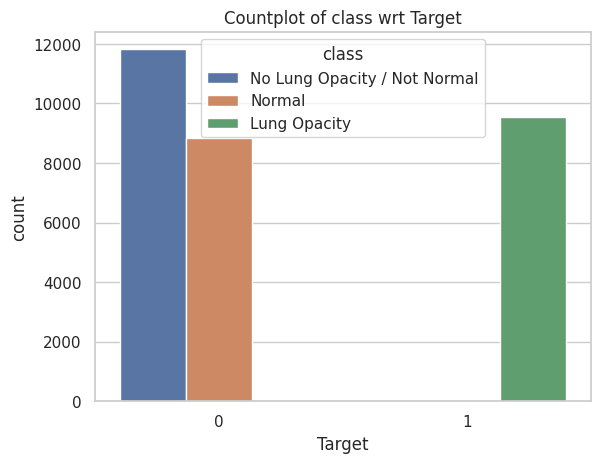

In [ ]:
sns.countplot(x=train_meta['Target'], hue=train_meta['class'])
plt.title('Countplot of class wrt Target')
plt.show()

There is no incongruence. If class = Lung Opacity, then Target = 1. And if Target = 1, class is necessarily Lung Opacity. In other words, all the 'abnormalities' with class = No Lung Opacity/Not Normal come under the category of Target=0.

In [ ]:
print('Number of images in train set is:', len(train_path))
print('Number of patients in csv file as per their Id is:', train_meta.patientId.nunique())
print('Number of images in test set is:', len(test_path))

Number of images in train set is: 26684
Number of patients in csv file as per their Id is: 26684
Number of images in test set is: 3000


##### So far we have been doing good. Their are no inconsistencies

##### Let us check the first image in the train set as per its index value in the corresponding meta table.

### DICOM

The size of the image is:  (1024, 1024) 

The pixel values of the image as a numpy array are:
 [[144 128 114 ... 176 184 117]
 [125 109  95 ... 171 178 111]
 [104  89  75 ... 166 175 108]
 ...
 [ 16  14  11 ...  19  15   3]
 [ 18  16  12 ...  21  17   5]
 [ 19  17  13 ...  23  19   6]] 

The image looks like:
 AxesImage(size=(1024, 1024))
The meta information saved in DICOM file is as follows:
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
------

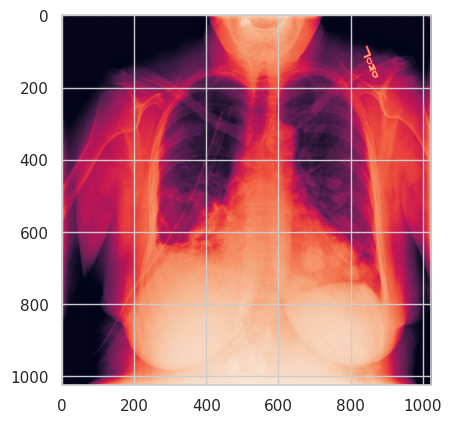

In [ ]:
first_img = train_meta.patientId[0]
img1_file = 'stage_2_train_images/%s.dcm' %first_img
img1_meta = pydicom.read_file(img1_file)

img1_px = img1_meta.pixel_array
print('The size of the image is: ', img1_px.shape, '\n')
print('The pixel values of the image as a numpy array are:\n', img1_px, '\n')
print('The image looks like:\n', plt.imshow(img1_px))
print('The meta information saved in DICOM file is as follows:')
print(img1_meta)

Most of the standard headers containing patient identifable information have been anonymized (removed) so we are left with a relatively sparse set of metadata. The primary field we will be accessing is the underlying pixel data.

A few inferences that can be made from the above meta data contained in the dicom

- A lot of infomation from the dicom has been removed. For example, we don't have the patient's name which is the same as their id. Also, there is no physician name and study id, nor is there the DOB of the patient.
- There are 1024 rows and columns in the image- which should be the standard size of all the images. We will check. Else we will have to resize all the images in one size before feeding them in a Deep Neural Network.
- It is monochrome i.e. grayscale.
- Every image takes up 8 bit of data.

### Bounding Boxes

In [ ]:
print('Total records for class information values:', train_class.shape[0])
print('Total number of bounding boxes:', train_labels.shape[0])
box_df = train_meta.groupby('patientId').size().reset_index(name='boxes')
train_meta = pd.merge(train_meta, box_df, on='patientId')
print('Distribution of number of boxes in the lungs of each patient:')
box_df = box_df.groupby('boxes').size().reset_index(name='patients')
print(box_df)

Total records for class information values: 26684
Total number of bounding boxes: 30227
Distribution of number of boxes in the lungs of each patient:
   boxes  patients
0      1     23286
1      2      3266
2      3       119
3      4        13


### Visualizing Images with bounding boxes

In [ ]:
vars = ['PatientAge','PatientSex','ImagePath']

def process_dicom_data(df, path):
    # adding new columns to the imported DataFrame with Null values
    for var in vars:
        df[var] = None
    images = os.listdir(path)
    #looping through each dicom image, extract the information from it, and 
    # add it to the DataFrame
    for i, img_name in enumerate(images):
        if(img_name=='stage_2_train_images/__MACOSX'):
          continue
        imagePath = os.path.join(path,img_name)
        img_data = pydicom.read_file(imagePath)
        idx = (df['patientId']==img_data.PatientID)
        df.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        df.loc[idx,'PatientSex'] = img_data.PatientSex
        df.loc[idx, 'ImagePath'] = str.format(imagePath)

In [ ]:
# saving the parsed data as DataFrame
process_dicom_data(train_meta,'stage_2_train_images')

Now, we subset a sample from the training set DataFrame so we have one example of every type of image.
We do this by successively grouping the training dataset by Target, class, and number of boxes
After that we plot the subsetted sample of images along with the boundings boxes on them, if any


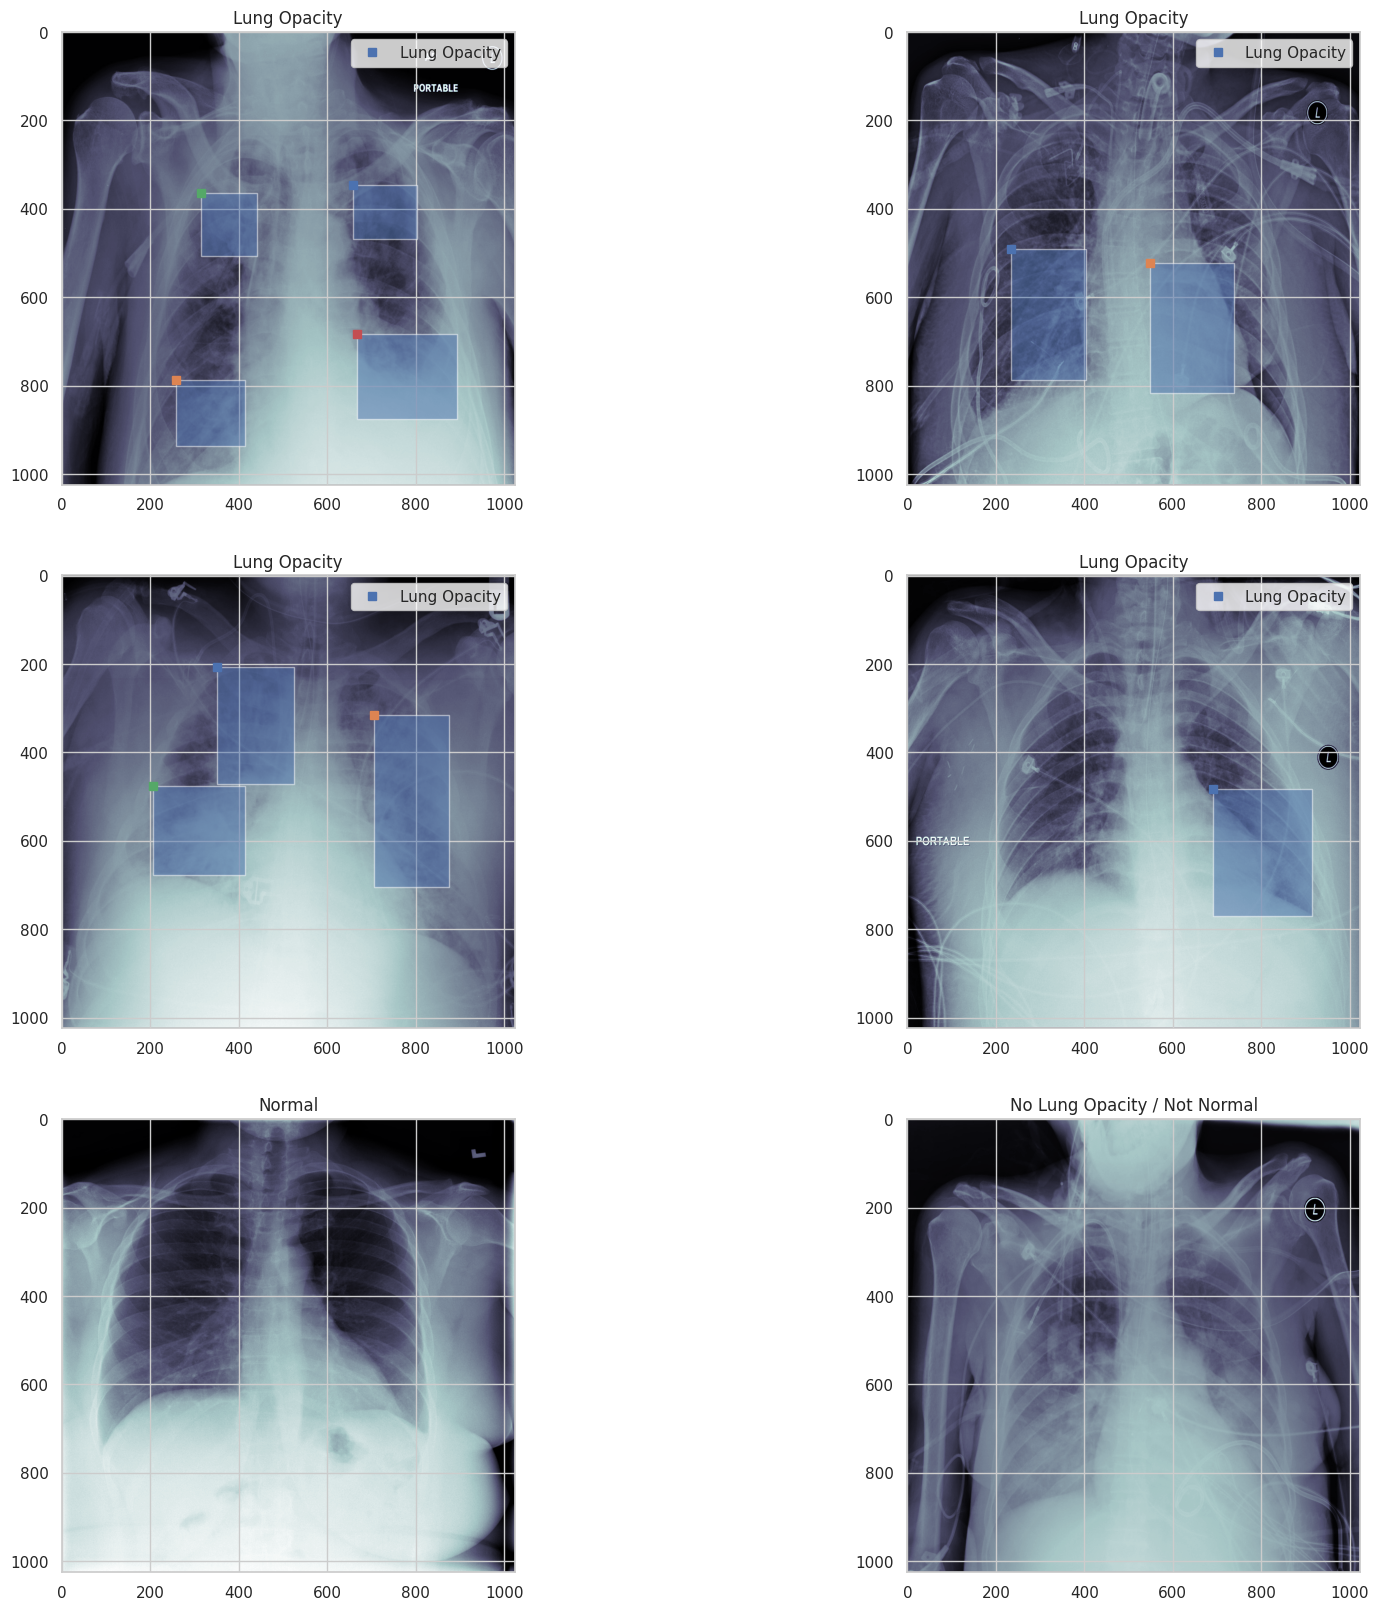

In [ ]:
print('Now, we subset a sample from the training set DataFrame so we have one example of every type of image.')
print('We do this by successively grouping the training dataset by Target, class, and number of boxes')
sample_df = train_meta.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)


print('After that we plot the subsetted sample of images along with the boundings boxes on them, if any')
fig, m_axs = plt.subplots(3, 2, figsize = (20, 20))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['ImagePath'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

In [ ]:
import cv2

In [ ]:
cwd = os.getcwd()
cwd

'/content/drive/MyDrive/Colab Notebooks'

In [ ]:
#(not(os.path.exists('stage_2_train_images/15fa29d8-09cf-436e-8bf8-cd85b260f2cc.dcm')))
# (not(os.path.exists('stage_2_train_images/0a0f91dc-6015-4342-b809-d19610854a21.dcm')))

In [ ]:
images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []

def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = 'stage_2_train_images/'+'{}.dcm'.format(patientId)

        # skipping the files where scans are not available
        if (not(os.path.exists(dcm_file))):
          continue
        dcm_data = pydicom.read_file(dcm_file)
        img = dcm_data.pixel_array
        
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

images, labels = populateImage(train_meta)
print(images.shape , labels.shape)

(30227, 128, 128, 3) (30227,)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
encode = LabelBinarizer()
y = encode.fit_transform(labels)

## splitting into train ,test and validation data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [ ]:
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Activation,Flatten,Dropout,MaxPooling2D,BatchNormalization

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses,optimizers

In [ ]:
## We start with 32 filters with 3,3 kernal and no padding , then 64 and 128 wiht drop layers in between 
## And softmax activaation as the last layer

def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))

  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = Adam(lr=0.001)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [ ]:
# Model Summary
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [ ]:
## Training for 20 epocs with batch size of 16
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 20, 
                  validation_data = (X_val,y_val),
                  batch_size = 16)

Epoch 1/20
1323/1323 [==============================] - 23s 8ms/step - loss: 1.1969 - accuracy: 0.4136 - val_loss: 1.0260 - val_accuracy: 0.4459
Epoch 2/20
1323/1323 [==============================] - 9s 7ms/step - loss: 1.0065 - accuracy: 0.4657 - val_loss: 1.0039 - val_accuracy: 0.4655
Epoch 3/20
1323/1323 [==============================] - 9s 7ms/step - loss: 0.9966 - accuracy: 0.4748 - val_loss: 0.9959 - val_accuracy: 0.4803
Epoch 4/20
1323/1323 [==============================] - 9s 7ms/step - loss: 0.9819 - accuracy: 0.4834 - val_loss: 0.9787 - val_accuracy: 0.4776
Epoch 5/20
1323/1323 [==============================] - 9s 7ms/step - loss: 0.9506 - accuracy: 0.5100 - val_loss: 0.9375 - val_accuracy: 0.5224
Epoch 6/20
1323/1323 [==============================] - 9s 7ms/step - loss: 0.9131 - accuracy: 0.5420 - val_loss: 0.8933 - val_accuracy: 0.5647
Epoch 7/20
1323/1323 [==============================] - 10s 7ms/step - loss: 0.8926 - accuracy: 0.5614 - val_loss: 0.8908 - val_accurac

In [ ]:
import tensorflow

In [ ]:
tensorflow. __version__

'2.12.0'

The Model got stuck at validation accuracy of 42%. Learning rate is too high. Using callbacks to improve learning rate and accuracy.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

In [ ]:
pip install keras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 20, 
                  validation_data = (X_val,y_val),
                  batch_size = 16,
                 callbacks = callbacks)

Epoch 1/20
1323/1323 [==============================] - 10s 8ms/step - loss: 0.7969 - accuracy: 0.6278 - val_loss: 0.8051 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 2/20
1323/1323 [==============================] - 9s 7ms/step - loss: 0.7910 - accuracy: 0.6262 - val_loss: 0.7984 - val_accuracy: 0.6549 - lr: 0.0010
Epoch 3/20
1323/1323 [==============================] - 9s 7ms/step - loss: 0.7865 - accuracy: 0.6350 - val_loss: 0.7942 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 4/20
1323/1323 [==============================] - 9s 7ms/step - loss: 0.7876 - accuracy: 0.6319 - val_loss: 0.8051 - val_accuracy: 0.6366 - lr: 0.0010
Epoch 5/20
1323/1323 [==============================] - 9s 7ms/step - loss: 0.8074 - accuracy: 0.6172 - val_loss: 0.7846 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 6/20
1323/1323 [==============================] - 9s 7ms/step - loss: 0.7788 - accuracy: 0.6350 - val_loss: 0.7956 - val_accuracy: 0.6388 - lr: 0.0010
Epoch 7/20
1323/1323 [==============================] - 9

Training accuracy is around 60.8% whereas validation accuracy is round 63.99%. We have avoided overfitting, but it seems to be clear that a normal CNN will not help us.

In [ ]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Loss (test data):', fcl_loss)
print('Accuracy (test data):', fcl_accuracy)

142/142 [==============================] - 1s 4ms/step - loss: 0.7611 - accuracy: 0.6610
Loss (test data): 0.7610962986946106
Accuracy (test data): 0.6610057353973389


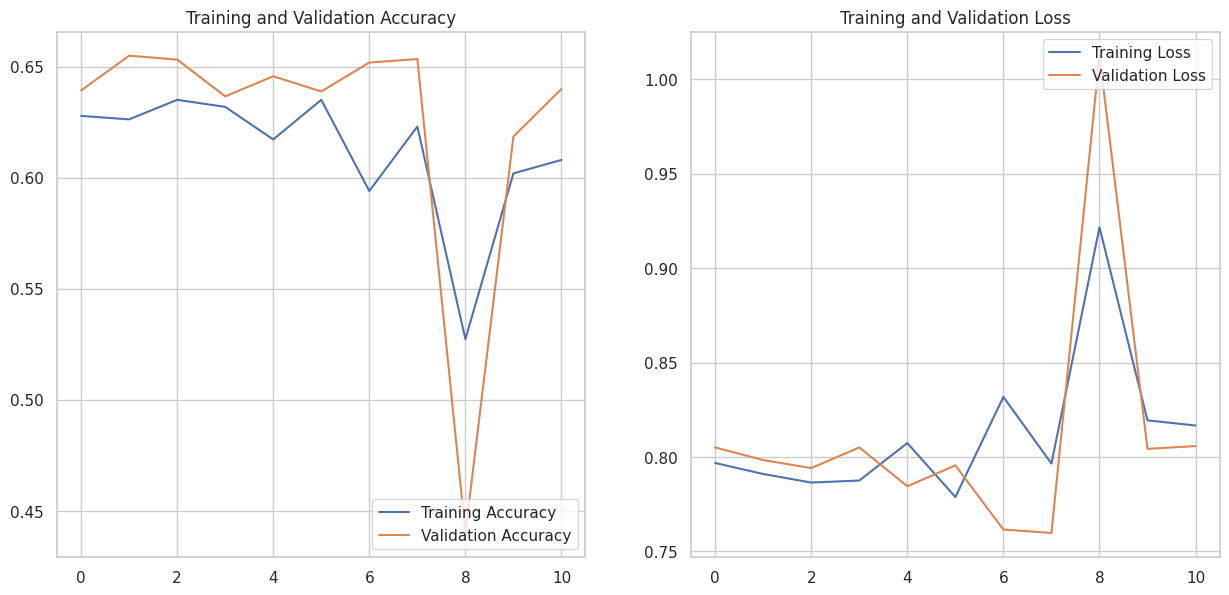

In [ ]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(11)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# The reason why the validation accuracy decreases in the later epochs could be due
# to the fact that we have processed only 200 images.

In [ ]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [ ]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

In [ ]:
resultDF

Method  accuracy  Test Score
0    CNN  0.607997    0.661006

142/142 [==============================] - 1s 3ms/step


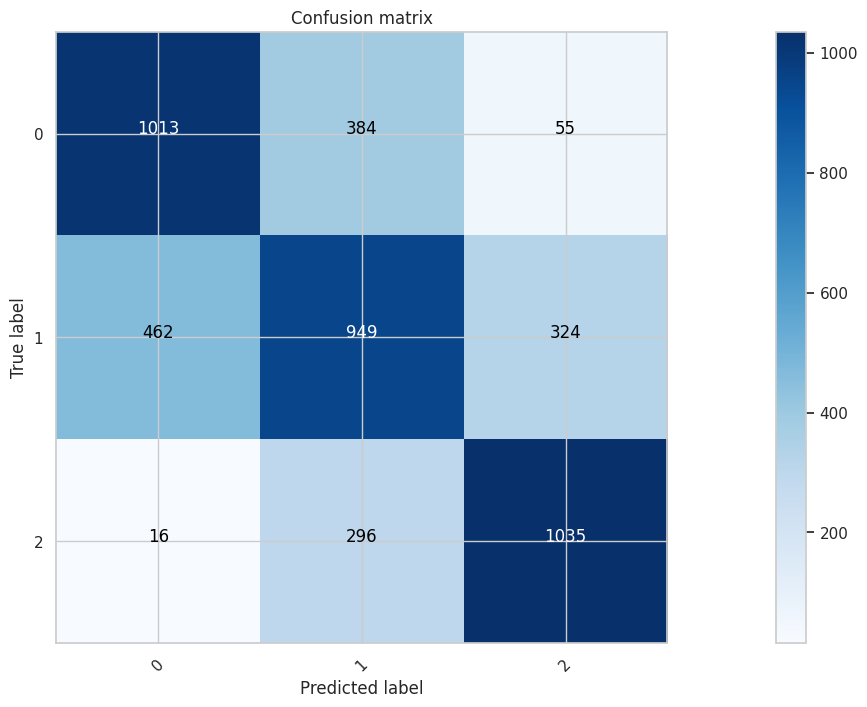

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

#Class 0 ,1 and 2
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error
#Class 2 is Normal

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

142/142 [==============================] - 0s 3ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  1_support
0    CNN  0.607997    0.661006     0.582566  0.546974    0.564209       1735

- The Accuracy for the above CNN model is 60.7%.
- Lets create another modal to get a higer accuracy.

In [8]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [9]:
PATH= "/content/drive/MyDrive/Colab Notebooks"

## Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row.

- If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations.
- If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary.

- The dictionary uses the filename as key and a list of pneumonia locations in that filename as value.
- If a filename is not present in the dictionary it means that it contains no pneumonia.

In [10]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join(PATH+'/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

- Split the list into two parts: train_filenames which is used to create a new dataset with 2560 samples, and valid_filenames which contains only those samples not in the train set

In [11]:
# load and shuffle filenames
folder = PATH+'/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

n train samples 24124
n valid samples 2560
Total train images: 26684
Images with pneumonia: 6012



## Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

- The generator takes in some filenames, batch_size and other parameters.

- The generator outputs a random batch of numpy images and numpy masks.

In [12]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia

        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        msk = resize(msk, (self.image_size, self.image_size), mode='symmetric') > 0.5
        
        

        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

## Network

In [13]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    # Added start
    #x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    #x = keras.layers.MaxPool2D(2)(x)
    # Added End
    return x


def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)

    #Added Start
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    #Added End
    
    addInput = x;
    print("Add input shape:", addInput.shape)
    print("Resnet block input shape:", inputs.shape)
    resBlockOut = keras.layers.add([addInput, inputs])
    print("Resnet block out shape:", resBlockOut.shape)
    out = keras.layers.concatenate([resBlockOut, addInput], axis=3)
    print("concat block out shape:", out.shape)
    out = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(out)
    print("mixed block out shape:", out.shape)
    return out

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Train Network

In [14]:
#IOU Loss function
# define iou or jaccard loss function

def iou_loss(y_true, y_pred):
    y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score


# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))


In [15]:
# create network and compiler
model = create_network(input_size=128, channels=16, n_blocks=2, depth=3)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])
print("model summary:", model.summary())
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 16, 16, 128)
Resnet block input shape: (None, 16, 16, 128)
Resnet block out shape: (None, 16, 16, 128)
concat block out shape: (None, 16, 

The execution time taken for each epoch took way too much time. Thus taking a sample of 1000 records each to execute further

In [17]:
# create train and validation generators
folder = PATH+'/stage_2_train_images'
train_gen = generator(folder, train_filenames[0:1000], pneumonia_locations, batch_size=16, image_size=128, shuffle=False, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames[1000:1200], pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)

#train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, augment=True, predict=False)
#valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, shuffle=True, verbose=2)

#history = model.fit_generator(train_gen, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)

Epoch 1/10
62/62 - 508s - loss: 0.5039 - accuracy: 0.9649 - mean_iou: 0.5739 - val_loss: 0.5192 - val_accuracy: 0.9403 - val_mean_iou: 0.3564 - lr: 0.0010 - 508s/epoch - 8s/step
Epoch 2/10
62/62 - 107s - loss: 0.4923 - accuracy: 0.9634 - mean_iou: 0.5710 - val_loss: 0.5107 - val_accuracy: 0.9722 - val_mean_iou: 0.6712 - lr: 9.9606e-04 - 107s/epoch - 2s/step
Epoch 3/10
62/62 - 108s - loss: 0.4825 - accuracy: 0.9651 - mean_iou: 0.6003 - val_loss: 0.4883 - val_accuracy: 0.9643 - val_mean_iou: 0.6233 - lr: 9.8429e-04 - 108s/epoch - 2s/step
Epoch 4/10
62/62 - 106s - loss: 0.4767 - accuracy: 0.9663 - mean_iou: 0.6034 - val_loss: 0.4731 - val_accuracy: 0.9663 - val_mean_iou: 0.6549 - lr: 9.6489e-04 - 106s/epoch - 2s/step
Epoch 5/10
62/62 - 106s - loss: 0.4794 - accuracy: 0.9677 - mean_iou: 0.6292 - val_loss: 0.4681 - val_accuracy: 0.9655 - val_mean_iou: 0.6344 - lr: 9.3815e-04 - 106s/epoch - 2s/step
Epoch 6/10
62/62 - 106s - loss: 0.4713 - accuracy: 0.9664 - mean_iou: 0.6370 - val_loss: 0.469

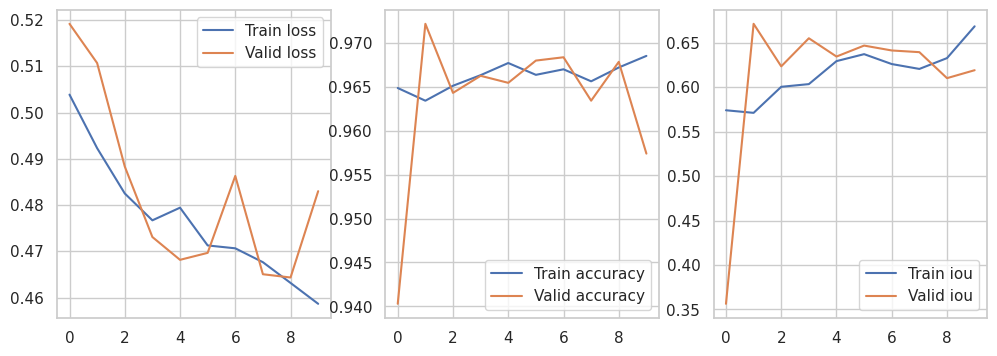

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [20]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=15, shuffle=True, verbose=2)


Epoch 1/15
62/62 - 109s - loss: 0.4697 - accuracy: 0.9677 - mean_iou: 0.6284 - val_loss: 0.4756 - val_accuracy: 0.9728 - val_mean_iou: 0.6836 - lr: 0.0010 - 109s/epoch - 2s/step
Epoch 2/15
62/62 - 108s - loss: 0.4611 - accuracy: 0.9677 - mean_iou: 0.6611 - val_loss: 0.4925 - val_accuracy: 0.9448 - val_mean_iou: 0.4710 - lr: 9.9606e-04 - 108s/epoch - 2s/step
Epoch 3/15
62/62 - 108s - loss: 0.4732 - accuracy: 0.9659 - mean_iou: 0.6249 - val_loss: 0.5764 - val_accuracy: 0.9724 - val_mean_iou: 0.7327 - lr: 9.8429e-04 - 108s/epoch - 2s/step
Epoch 4/15
62/62 - 107s - loss: 0.4651 - accuracy: 0.9676 - mean_iou: 0.6433 - val_loss: 0.4971 - val_accuracy: 0.9450 - val_mean_iou: 0.5168 - lr: 9.6489e-04 - 107s/epoch - 2s/step
Epoch 5/15
62/62 - 105s - loss: 0.4641 - accuracy: 0.9664 - mean_iou: 0.6371 - val_loss: 0.4712 - val_accuracy: 0.9499 - val_mean_iou: 0.5576 - lr: 9.3815e-04 - 105s/epoch - 2s/step
Epoch 6/15
62/62 - 107s - loss: 0.4573 - accuracy: 0.9682 - mean_iou: 0.6463 - val_loss: 0.467

Training accuracy is around 97.24% whereas validation accuracy is round 96.4%.

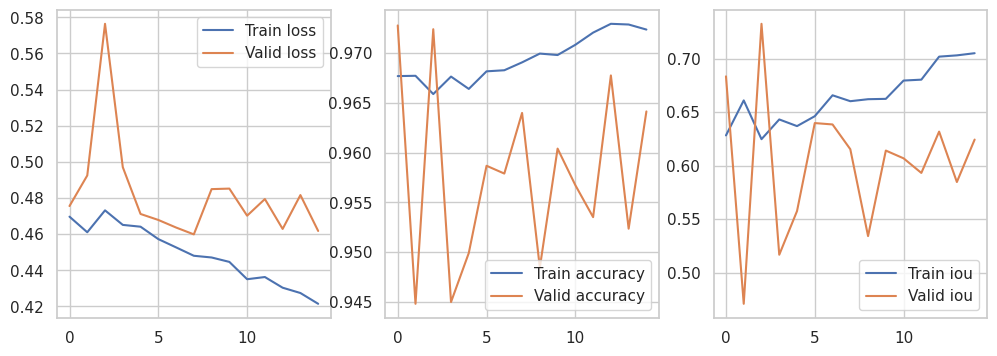

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [22]:
model.save('./Mixed_link_model-1.h5')

1/1 [==============================] - 0s 404ms/step


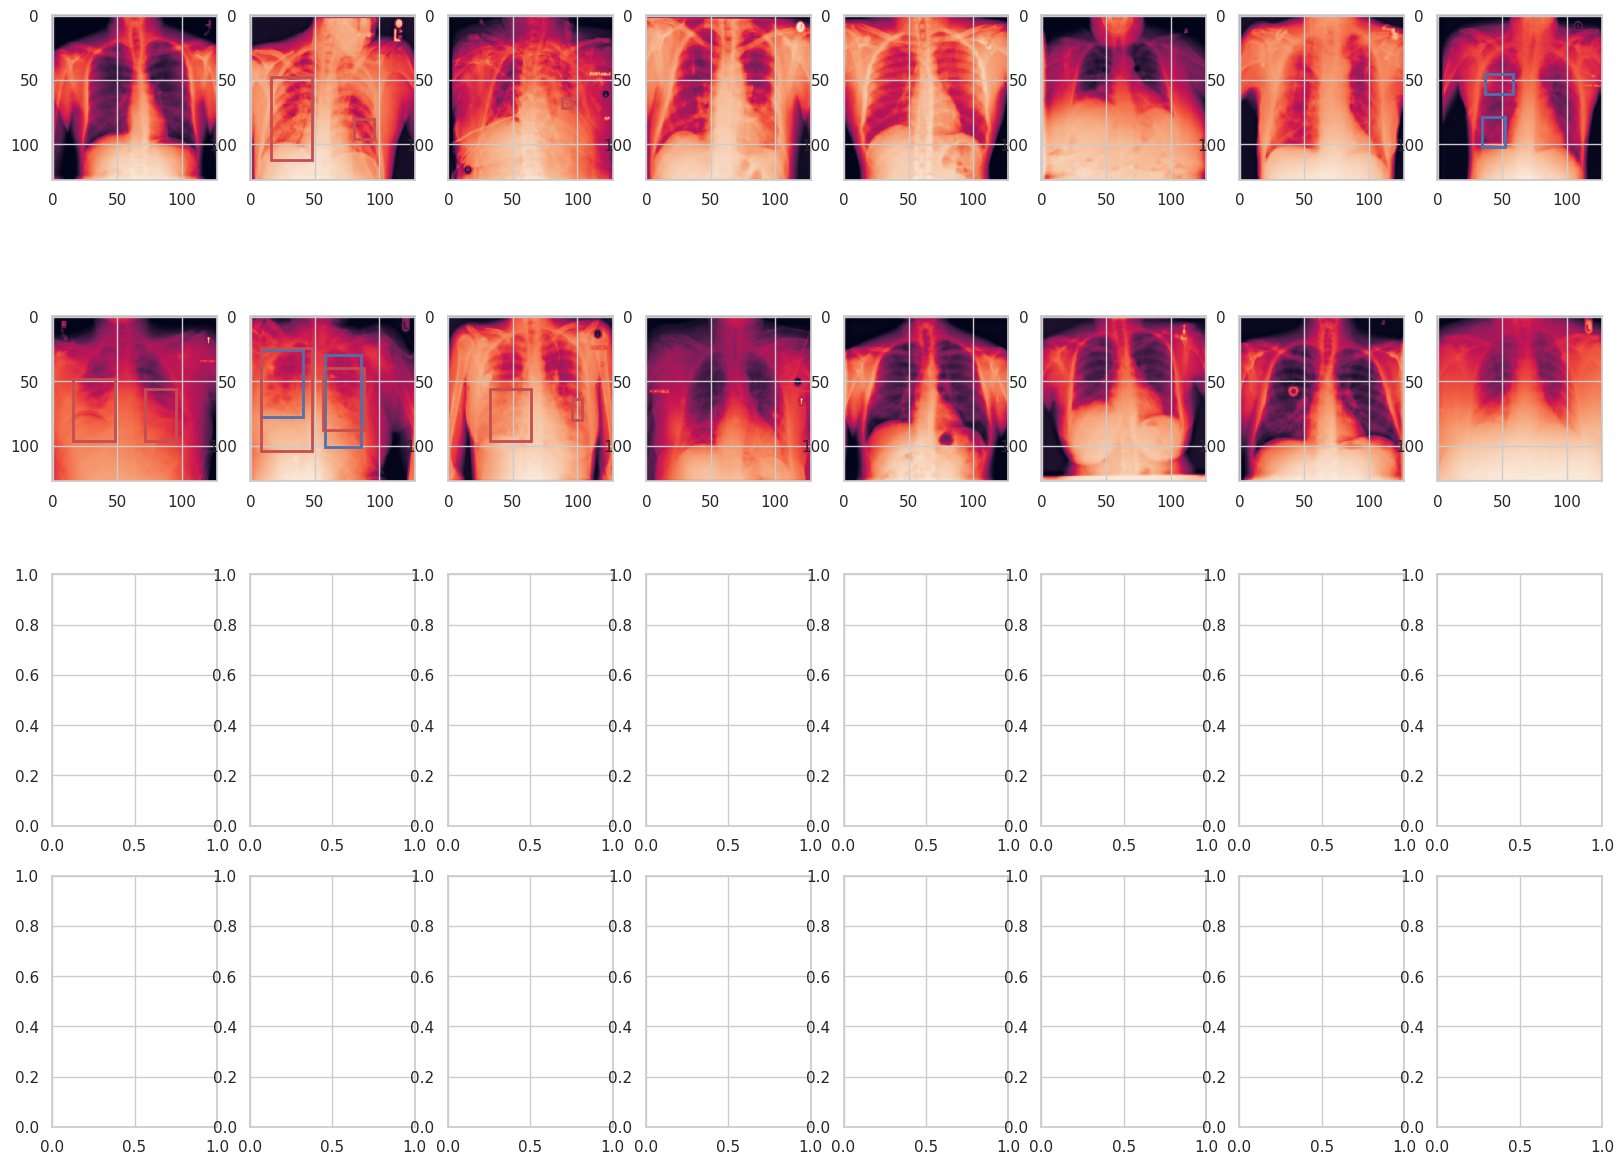

In [23]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break